# **Setup** (run once)

In [8]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-11-08 16:58:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-11-08 16:58:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-11-08 16:58:07--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [9]:
!unzip -q glove.6B.zip

# **Imports**

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import fetch_20newsgroups
from tensorflow import keras
from keras.layers import Embedding
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## **1. Load Data**

In [2]:
# Retrieve 20NewsGroup dataset
dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers'))
samples = dataset.data
labels = dataset.target

## **2. Data Pre-Processing**

In [3]:
# Model Constants
LSTM_DIMENSION_SIZE = 100
ENCODED_VECTOR_SIZE = 300 # 50, 100, 200, 300
NUM_CLASSES = 20

## **3. Data Vectorization**

In [4]:
# Tokenize words from samples
tokenizer = Tokenizer()
tokenizer.fit_on_texts(samples)
num_words = len(tokenizer.word_index) + 1

# Convert to vetorized sequences and pad sequences to all be same size
sequences = tokenizer.texts_to_sequences(samples)
padded_sequences = pad_sequences(sequences, maxlen=ENCODED_VECTOR_SIZE)

x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, shuffle=True)

## **4. Pre-Trained Embeddings**

In [5]:
#Load pre-trained word embeddings
path_to_glove_file =  "glove.6B.300d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [6]:
# Embedding Matrix
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_words, ENCODED_VECTOR_SIZE))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in pre-trained embeddings will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 63417 words (94759 misses)


# **5. Model Definition**

In [9]:
# LSTM Model
model = keras.Sequential()
model.add(Embedding(num_words, ENCODED_VECTOR_SIZE, embeddings_initializer=keras.initializers.Constant(embedding_matrix),trainable=False))
model.add(LSTM(LSTM_DIMENSION_SIZE))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         47453100  
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 20)                2020      
                                                                 
Total params: 47615520 (181.64 MB)
Trainable params: 162420 (634.45 KB)
Non-trainable params: 47453100 (181.02 MB)
_________________________________________________________________
None


## **6. Model Training + Validation**

In [10]:
model_history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_split=0.1)

Epoch 1/20
106/106 [==============================] - 49s 454ms/step - loss: 2.4542 - accuracy: 0.2162 - val_loss: 2.1483 - val_accuracy: 0.3090
Epoch 2/20
106/106 [==============================] - 53s 493ms/step - loss: 1.9315 - accuracy: 0.3687 - val_loss: 1.7997 - val_accuracy: 0.4244
Epoch 3/20
106/106 [==============================] - 50s 467ms/step - loss: 1.5674 - accuracy: 0.4810 - val_loss: 1.5252 - val_accuracy: 0.4828
Epoch 4/20
106/106 [==============================] - 50s 471ms/step - loss: 1.3767 - accuracy: 0.5449 - val_loss: 1.3084 - val_accuracy: 0.5656
Epoch 5/20
106/106 [==============================] - 49s 461ms/step - loss: 1.1935 - accuracy: 0.6078 - val_loss: 1.2097 - val_accuracy: 0.5895
Epoch 6/20
106/106 [==============================] - 49s 461ms/step - loss: 1.0657 - accuracy: 0.6543 - val_loss: 1.1160 - val_accuracy: 0.6466
Epoch 7/20
106/106 [==============================] - 63s 593ms/step - loss: 0.9799 - accuracy: 0.6848 - val_loss: 1.1651 - val_ac

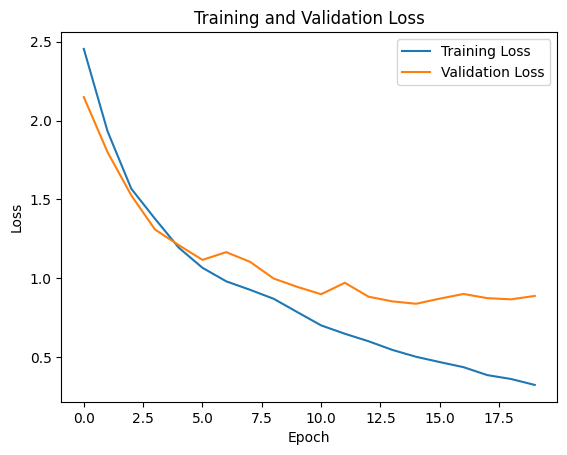

In [11]:
# plot loss curves
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

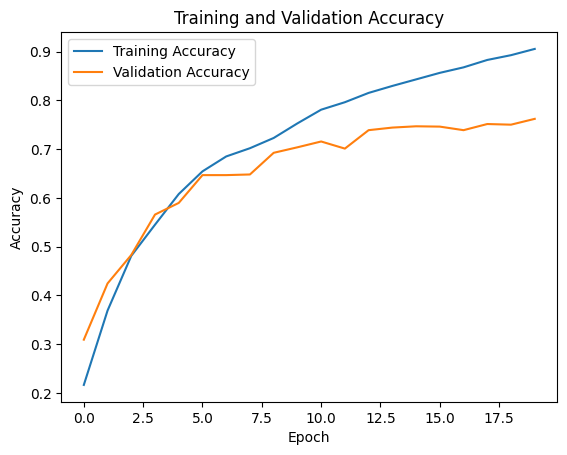

In [13]:
# plot accuracy curves
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **7. Model Testing**

In [14]:
# get predictions and calculate accuracy
predictions = np.argmax(model.predict(x_test), axis=1)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

118/118 [==============================] - 9s 70ms/step
Accuracy: 0.7557029177718833


## **8. Model Comparison**